In [1]:
import sys

sys.path.append('.')

import model

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import random
import seaborn as sns
import statistics

# 2D Lattice with rewiring

We start with an $m \times n$ periodic square lattice.

In [3]:
N, M = (45, 45)

g = nx.grid_2d_graph(N, M, periodic=True, create_using=None)

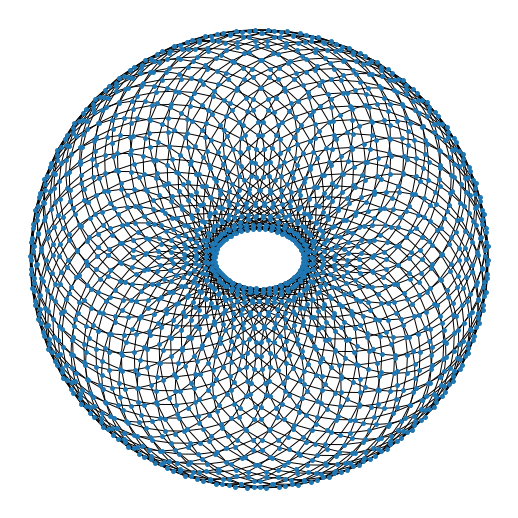

In [4]:
plt.figure(3,figsize=(7,7)) 
## draw_spectral for the lattice
nx.draw_spectral(g,
                node_size = 15)

Then for each edge $(u,v)$, with probability $p$, we replace that edge with a new edge $(u,w)$, where $w$ is randomly sampled from the existing nodes.

In [5]:
g = model.grid_r(N,M, 0.1)

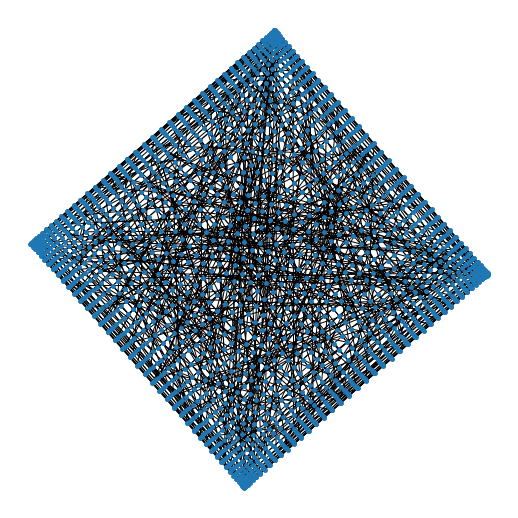

In [6]:
plt.figure(3,figsize=(7,7)) 
## draw_spectral for the lattice
nx.draw(g,
        pos = model.grid_pos(g),
        node_size = 15)

# Looking at infection on the 2D lattice, no contact tracing

We will keep $n = 45$, $m = 45$, which keeps the total number of nodes comparable to the earlier Watts-Strogatz based study.

What is the effect of rewiring rate $p$ on infection, without tracing?

In [7]:
## Population parameters:
base_params = {
    # Node parameter
    'A' : 0.5, 
    
    # Edge parameter
    'W' : .5, # probability of edge activation; 2/K
    'C' : 1.0,
    
    ## Disease parameters

    'beta_hat' : .4, # probability of transmission upon contact
    'alpha' : .25, # probability of exposed becoming infectious
    'gamma' : .1, # probability of infectious becoming recovered
    'zeta' : .1, # probability of infectious becoming symptomatic

    ## Contact tracing parameters

    'limit' : 10, # number of time steps the contact tracing system remembers
}

In [8]:
## Illustrative single simulation

In [9]:
g_live = model.initialize_graph(g, base_params)

t = 0
#g_live = g.copy()
#initialize(g_live,params)
history = {}

s_count = []

while len(model.get_infected(g_live)) > 0 and t < float("inf"):
    if t != 0 and t % len(g_live.nodes()) / 100 == 0:
        print("Trial %d hits time step %d" % (i,t))

    s_count.append(len(model.susceptible(g_live)))

    g_live, history = model.loop(base_params, g_live, history, t)

    t = t + 1

In [10]:
print(model.green_cmap(0))
print(model.green_cmap(t))

(0.9686274509803922, 0.9882352941176471, 0.9607843137254902, 1.0)
(0.8495963091118801, 0.9414071510957325, 0.8267589388696656, 1.0)


In [11]:
list(g_live.edges(data=True))[20]

((0, 5), (44, 5), {'w': 0.5, 'c': 1.0})

In [12]:
#[int(model.edge_adopter(g_live,e)) for e in g_live.edges(data=True)]

In [13]:
list(g_live.edges(data=True))[20][2]['c'] * int(model.edge_adopter(g_live, list(g_live.edges(data=True))[20]))

0.0

/home/sb/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


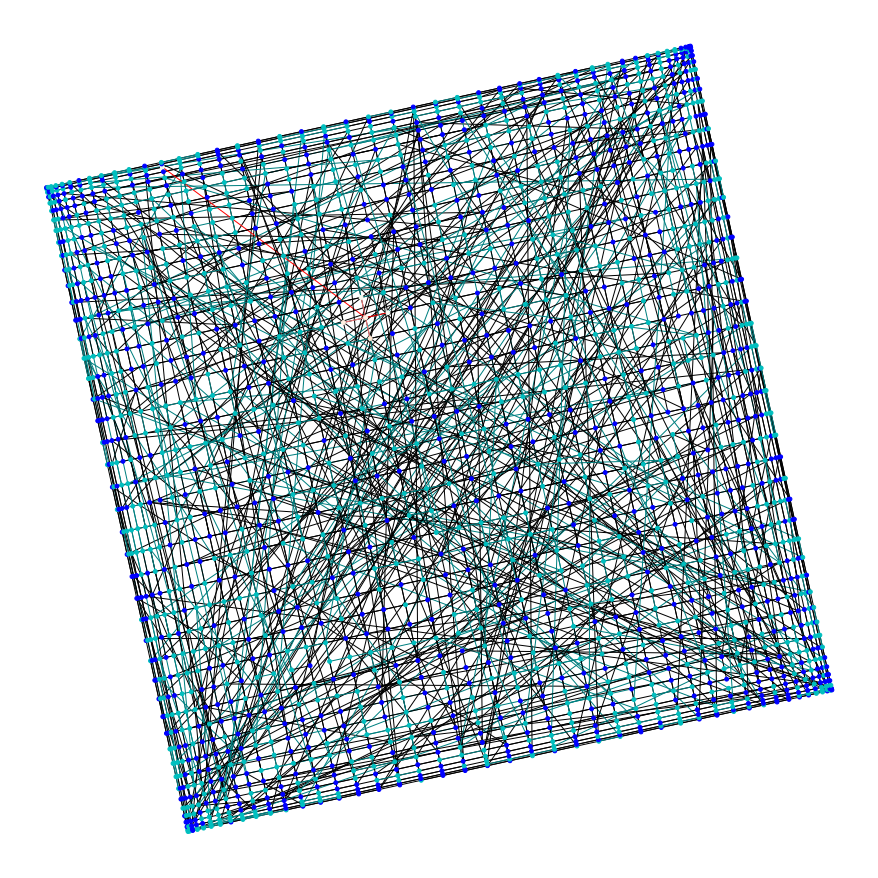

In [14]:
plt.figure(3,figsize=(12,12)) 
## draw_spectral for the lattice
nx.draw(g_live,
        pos = model.grid_pos(g_live),
        node_color = model.node_colors(g_live),
        edge_color = model.edge_colors(g_live),
        node_size = 15)

In [15]:
g_live.nodes[(0,0)]

{'adopter': True,
 'group': 1,
 'quarantined': False,
 'symptomatic': False,
 'tested': False,
 'epi-state': 'Susceptible'}

## Larger scale simulation

In [16]:
base_params['A'] = 0.0
base_params['C'] = 0.0

In [17]:
def square_lattice_rewiring_case(N, M, p, **kwargs):

    g = nx.grid_2d_graph(N, M, periodic=True)

    for e in g.edges:
        if random.random() <= p:
            g.remove_edge(e[0],e[1])
            v = random.choice(list(g.nodes()))
            g.add_edge(e[0], v)

    g.graph['N'] = N
    g.graph['M'] = M
    g.graph['p'] = p

    return g, kwargs


def square_r_case_generator(N, M, **kwargs):
    def sqrg(**kwargs):
        return square_lattice_rewiring_case(N, M, **kwargs)
    
    return sqrg

In [18]:
conditions = {
    'p-0.000' : {'p' : 0.000},
    'p-0.005' : {'p' : 0.005},
    'p-0.010' : {'p' : 0.010},
    'p-0.025' : {'p' : 0.025},
    'p-0.050' : {'p' : 0.050},
    'p-0.075' : {'p' : 0.075},
    'p-0.100' : {'p' : 0.100},
    'p-0.250' : {'p' : 0.250},
    'p-0.500' : {'p' : 0.500},
    'p-0.750' : {'p' : 0.750},
    'p-1.000' : {'p' : 1.00},
}

In [19]:
def dfr(rs):
    return pd.DataFrame(
        [r for case in rs 
         for r in model.data_from_results(rs, case)])

In [20]:
#runs = 100

#N, M = (45, 45)

#results = model.experiment(
#    square_r_case_generator(N, M),
#    base_params,
#    conditions,
#    runs
#)
#
#temp = dfr(results)
#temp.to_csv('p_square_study.csv')

In [21]:
#temp = dfr(results)
#temp.to_csv('p_square_study.csv')
temp = pd.read_csv('p_square_study.csv')

In [22]:
temp.columns

Index(['Unnamed: 0', 'time', 'A', 'W', 'C', 'beta_hat', 'alpha', 'gamma',
       'zeta', 'limit', 'N', 'M', 'p', 's_final', 'route_adjacent_ratio',
       'traced_edges', 'traced_edges_distant', 'group 0 adoption rate',
       'group 1 adoption rate', 'avg. exp. interval - group 0',
       'avg. exp. interval - group 1', 'avg. eff. inf. interval - group 0',
       'avg. eff. inf. interval - group 1', 'case', 'infected_ratio'],
      dtype='object')

**Infected ratio** needs to be reset because we calculate it originally using a different sense of _N_.

In [23]:
temp['nodes'] = temp['N'] * temp['M']
temp['infected_ratio'] = (temp['nodes'] - temp['s_final']) / temp['nodes']

[Text(0.5, 1.0, '2D Lattice Rewiring and Infectiousness'),
 Text(0.5, 0, 'rewiring rate'),
 Text(0, 0.5, 'infected ratio')]

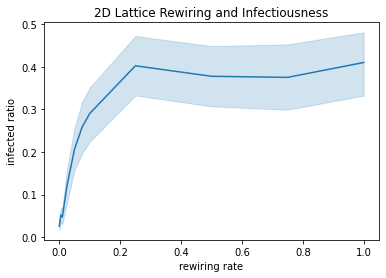

In [24]:
splot = sns.lineplot(x='p', y='infected_ratio', data=temp)
splot.set(title='2D Lattice Rewiring and Infectiousness', xlabel='rewiring rate', ylabel='infected ratio')

In [25]:
## Population parameters:
base_params_A = {
    
    'p' : 0.1, ## picking a p-star
    
    # Node parameter
    'A' : 0.0, # This will vary by condition
    
    # Edge parameter
    'W' : .5, # probability of edge activation; 2/K
    'C' : 1.0, ## no edges can be traced.
    
    ## Disease parameters

    'beta_hat' : .4, # probability of transmission upon contact
    'alpha' : .25, # probability of exposed becoming infectious
    'gamma' : .1, # probability of infectious becoming recovered
    'zeta' : .1, # probability of infectious becoming symptomatic

    ## Contact tracing parameters

    'limit' : 10, # number of time steps the contact tracing system remembers
}

In [26]:
conditions_A = {
    'A-0.000' : {'A' : 0.000},
    'A-0.005' : {'A' : 0.005},
    'A-0.007' : {'A' : 0.007},
    'A-0.010' : {'A' : 0.010},
    'A-0.025' : {'A' : 0.025},
    'A-0.050' : {'A' : 0.050},
    'A-0.075' : {'A' : 0.075},
    'A-0.100' : {'A' : 0.100},
    'A-0.200' : {'A' : 0.200},
    'A-0.30' : {'A' : 0.30},
    'A-0.500' : {'A' : 0.500},
    'A-0.750' : {'A' : 0.750},
    'A-1.000' : {'A' : 1.00},
}

In [27]:
#runs = 200

#N, M = (45, 45)

#results = model.experiment(
#    square_r_case_generator(N, M),
#    base_params_A,
#    conditions_A,
#    runs
#)

#temp_A = dfr(results)
#temp_A.to_csv('A_square_study.csv')

In [28]:
temp = pd.read_csv('A_square_study.csv')

temp['nodes'] = temp['N'] * temp['M']
temp['infected_ratio'] = (temp['nodes'] - temp['s_final']) / temp['nodes']

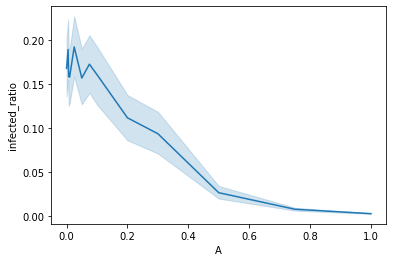

In [29]:
splot = sns.lineplot(x='A', y='infected_ratio', data=temp)

$\Sigma x^2$

In [30]:
## Population parameters:
base_params_QR = {
    # will this work?
    'p' : 0.1,
    
    # Node parameter
    'A' : 1.0, # 
    
    # Edge parameter
    'W' : .5, # probability of edge activation; 2/K
    'C' : 1.0, ## all edges can be traced.
    
    ## Disease parameters

    'beta_hat' : .4, # probability of transmission upon contact
    'alpha' : .25, # probability of exposed becoming infectious
    'gamma' : .1, # probability of infectious becoming recovered
    'zeta' : .1, # probability of infectious becoming symptomatic

    ## Contact tracing parameters

    'limit' : 10, # number of time steps the contact tracing system remembers
}

In [31]:
conditions_QR = {}

q_range = np.arange(0, 1, 0.1)
r_range = np.arange(0, 1, 0.05)

for q in q_range:
    for r in r_range:
        conditions_QR[f'q-{q}_r-{r}'] = {
            'C' : model.qr_knockout_lattice(q, r),
            'q' : q,
            'r' : r
        }
        
print(len(conditions_QR))

200


In [32]:
#runs = 100

N, M = (45, 45)

#results = model.experiment(
#    square_r_case_generator(N, M),
#    base_params_QR,
#    conditions_QR,
#    runs
#)

#temp_QR = dfr(results)
#temp_QR.to_csv('QR_square_study.csv')

In [33]:
data = pd.read_csv('QR_square_study.csv')

data['traced_edges_close'] = data['traced_edges'] - data['traced_edges_distant']
data['traced_edges_ratio'] = data['traced_edges'] / (data['N'] * data['M'] * 2)
data['traced_edges_distant_ratio'] = data['traced_edges_distant'] / data['traced_edges']

data['D'] = (data['p'] * data['q']) / ((1 - data['p']) * data['r'] + data['p'] * data['q'])
data['T'] = ((1 - data['p']) * data['r'] + data['p'] * data['q'])

data['nodes'] = data['N'] * data['M']
data['infected_ratio'] = (data['nodes'] - data['s_final']) / data['nodes']

In [34]:
data['N'] * data['M'] * 2 * data['p']

0        405.0
1        405.0
2        405.0
3        405.0
4        405.0
         ...  
19995    405.0
19996    405.0
19997    405.0
19998    405.0
19999    405.0
Length: 20000, dtype: float64

In [35]:
data['N'] * data['M'] * 2 * (1 - data['p'])

0        3645.0
1        3645.0
2        3645.0
3        3645.0
4        3645.0
          ...  
19995    3645.0
19996    3645.0
19997    3645.0
19998    3645.0
19999    3645.0
Length: 20000, dtype: float64

In [45]:
data.columns

Index(['Unnamed: 0', 'time', 'A', 'W', 'C', 'beta_hat', 'alpha', 'gamma',
       'zeta', 'limit', 'q', 'r', 'N', 'M', 'p', 's_final',
       'route_adjacent_ratio', 'traced_edges', 'traced_edges_distant',
       'group 0 adoption rate', 'group 1 adoption rate',
       'avg. exp. interval - group 0', 'avg. exp. interval - group 1',
       'avg. eff. inf. interval - group 0',
       'avg. eff. inf. interval - group 1', 'case', 'infected_ratio',
       'traced_edges_close', 'traced_edges_ratio',
       'traced_edges_distant_ratio', 'D', 'T', 'nodes'],
      dtype='object')

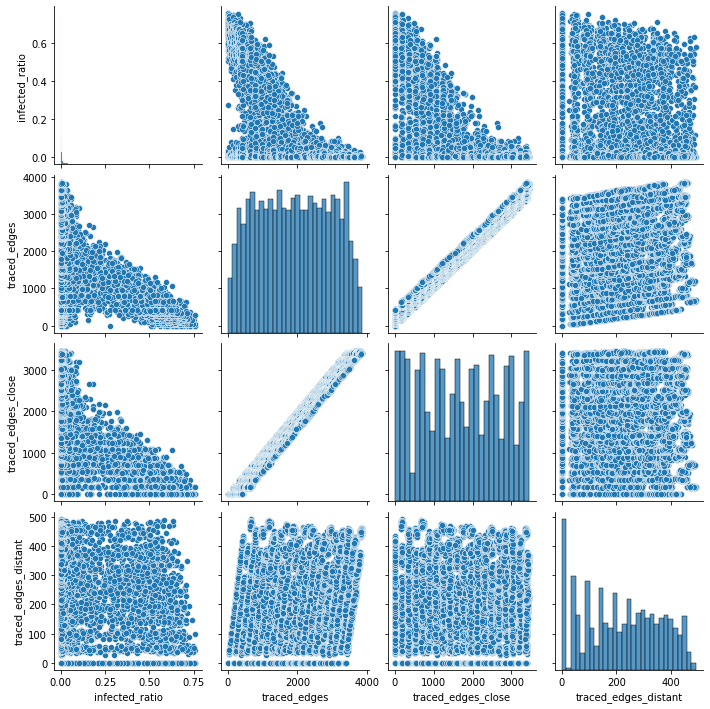

In [36]:
sns.pairplot(
    data[[
        'infected_ratio',
        'traced_edges',
        'traced_edges_close',
        'traced_edges_distant'
    ]
    ])

In [47]:
g = sns.scatterplot(
    data = data,
    y = 'infected_ratio',
    x = 'traced_edges',
    hue = 'traced_edges_distant'
)

RuntimeError: latex was not able to process the following string:
b'traced_edges'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/home/sb/.cache/matplotlib/tex.cache/0224941bb0451c690614522520de5636.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
(./0224941bb0451c690614522520de5636.aux)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\rmfamily traced_
                       edges}
No pages of output.
Transcript written on 0224941bb0451c690614522520de5636.log.




<Figure size 432x288 with 1 Axes>

[Text(0.5, 1.0, 'Infected ratio with variable tracing'),
 Text(0.5, 15.0, 'traced edges: distant'),
 Text(33.0, 0.5, 'traced edges: close')]

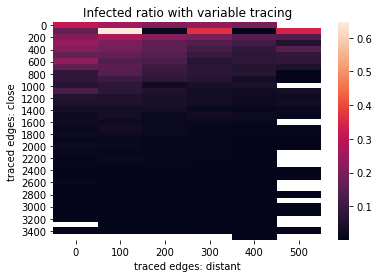

In [38]:
base = 100

g, xyz, db = model.binned_heatmap(
    data,
    x = 'traced_edges_distant',
    x_base = base,
    y = 'traced_edges_close',
    y_base = base,
    z = 'infected_ratio'
)

g.set(#xscale="log",
      title='Infected ratio with variable tracing',
      xlabel='traced edges: distant',
      ylabel='traced edges: close')

In [39]:
xyz.shape

(36, 6)

In [40]:
list(xyz.columns)

[0, 100, 200, 300, 400, 500]

In [41]:
wxyz = pd.melt(
    xyz.reset_index(),
    id_vars="y_bin",
    value_vars=list(xyz.columns),
    value_name="infected_ratio"
)

wxyz

,y_bin,x_bin,infected_ratio
0,0,0,0.314109
1,100,0,0.164321
2,200,0,0.210778
3,300,0,0.248257
4,400,0,0.213406
...,...,...,...
211,3100,500,0.001975
212,3200,500,NaN
213,3300,500,NaN
214,3400,500,0.003654


<AxesSubplot:xlabel='y_bin', ylabel='infected_ratio'>

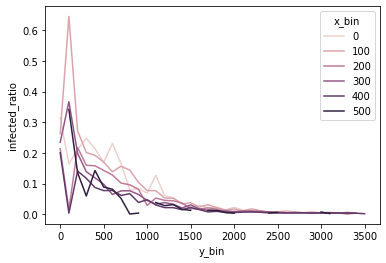

In [42]:
sns.lineplot(
    x='y_bin',
    y='infected_ratio',
    hue='x_bin',
    data=wxyz
)

Text(0.5, 0, 'Traced edges')

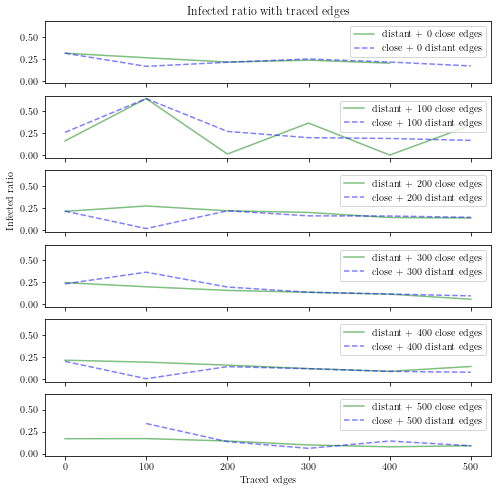

In [43]:
num_plots = 6

plt.rc('font', family='serif')
plt.rc('text', usetex=True)

fig, ax = plt.subplots(
    num_plots, 1,
    sharex='col',
    sharey='col',
    figsize=(8,8),
)

x_range = list(range(0, xyz.shape[1] * base, base))

for i in range(num_plots):
    ax[i].plot(
        x_range,
        xyz.values[i,:],
        'g',
        alpha=0.5,
        label=f"distant + {i * base} close edges"
    )
    
for i in range(num_plots):
    ax[i].plot(
        x_range,
        xyz.values[:len(x_range),i],
        "b--",
        alpha=0.5,
        label=f"close + {i * base} distant edges"
    )
    ax[i].legend()
    
ax[0].set_title("Infected ratio with traced edges")
ax[2].set_ylabel("Infected ratio")
ax[5].set_xlabel("Traced edges")